# General Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

random_seed = 1

In [2]:
import os

"""
Launch the script to generate the data.
"""
def generate_data(number_buildings):
    string_number_buildings = str(number_buildings)
    status = os.system('inst_gen.py -s ' + string_number_buildings)
    if status == 0 : 
        print('SUCCESS : Data generation with ' + string_number_buildings + ' buildings')
        return 'N' + string_number_buildings + '_0'
    else : 
        print('FAILURE : Data generation with ' + string_number_buildings + ' buildings')
        return ''

"""
Import the data.
"""
def import_data(directory):
    return np.genfromtxt(directory, delimiter=' ', dtype=None, usecols=range(0,3), skip_header=1)

In [3]:
"""
Generate the critical points from the building data.
"""
def find_critical_points(imported_data):
    number_buildings = len(imported_data)

    upper_left_critical_point = np.array([imported_data[:, 0], imported_data[:, 2]]).T
    lower_right_critical_point = np.array([imported_data[:, 1], np.zeros(number_buildings, dtype=np.int8)]).T
    critical_points = np.column_stack([upper_left_critical_point, lower_right_critical_point]).reshape((-1,2))

    return critical_points

In [4]:
"""
Visualize buildings data.
"""
def plot_data(buildings_data):
    buildings_list_x = []
    buildings_list_y = []
    for building in buildings_data:
        building_to_plot = []
        building_to_plot.append([building[0], 0])
        building_to_plot.append([building[0], building[2]])
        building_to_plot.append([building[1], building[2]])
        building_to_plot.append([building[1], 0])

        building_to_plot = np.array(building_to_plot)
        building_x = building_to_plot[:, 0]
        building_y = building_to_plot[:, 1]

        buildings_list_x.append(building_x)
        buildings_list_y.append(building_y)

    plt.figure(figsize=(10,8))    
    np.random.seed(random_seed)
    for i in range(len(buildings_list_x)):
        colors = np.random.rand(3)
        plt.plot(buildings_list_x[i], buildings_list_y[i], c=colors)
    plt.title("Data Visualization")
    plt.xlabel("Horizon")
    plt.ylabel("Height")
    plt.grid()
    plt.show()

In [5]:
"""
Visualize solution.
"""
def plot_solution(critial_points_kept):
    points_to_plot = [[0, 0]]
    for point in critial_points_kept:
        last_point = points_to_plot[-1]
        points_to_plot.append([point[0], last_point[1]])
        points_to_plot.append([point[0], point[1]])
    last_point = points_to_plot[-1]
    # points_to_plot.append([last_point[0]+10, 0])
    points_to_plot = points_to_plot[1:]

    points_to_plot = np.array(points_to_plot)
    x_to_plot = points_to_plot[:,0]
    y_to_plot = points_to_plot[:,1]

    x_critical_points = critial_points_kept[:,0]
    y_critical_points = critial_points_kept[:,1]

    plt.figure(figsize=(10,8))
    plt.plot(x_to_plot, y_to_plot, color='black', label='Skyline Solution')
    plt.scatter(x_critical_points, y_critical_points, color='red', label='Critical points')
    plt.title("Skyline Solution")
    plt.xlabel("Horizon")
    plt.ylabel("Height")
    plt.legend()
    plt.grid()
    plt.show()

# Data Generation

In [6]:
generated_file_name = generate_data(number_buildings=30)
buildings_data = import_data(generated_file_name)
critical_points = find_critical_points(buildings_data)

SUCCESS : Data generation with 30 buildings


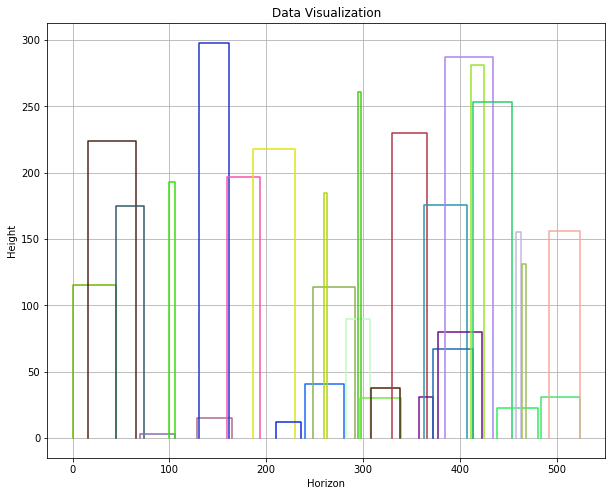

In [7]:
plot_data(buildings_data)

# Brute Force Algorithm

## Definitions

In [8]:
# Pseudocode :

# Sort the points critical points accorting to their x axis
# FOR every critical points
#     FOR every building
#         IF (the critical point is in a building) AND (the height is below the building height)
#             Raise the critical point
#
#     IF the critical point is not redundant
#         Add the critical points to the solution

def brute_force_solve(buildings_data, must_compute_time=True):
    
    if must_compute_time :
        start_time = time.time()
    
    critical_points = find_critical_points(buildings_data)
    sorted_critical_points = critical_points[np.argsort(critical_points, axis=0)[:, 0]]
    
    points_to_keep = [[-1,0]]
    for point in sorted_critical_points:
        for building in buildings_data:
            if point[0] > building[0] and point[0] < building[1] and point[1] < building[2]:
                point[1] = building[2]

            if point[0] < building[0]:
                break
        
        previous_point_kept = points_to_keep[-1]
        if previous_point_kept[1] != point[1]:
            if point[0] == previous_point_kept[0]:
                if point[1] > previous_point_kept[1]:
                    points_to_keep.pop()
                    points_to_keep.append(point)
                
            else :
                points_to_keep.append(point)

    points_to_keep = np.array(points_to_keep[1:])
    
    if must_compute_time :
        end_time = time.time()
        computation_time = end_time - start_time
        return (points_to_keep, computation_time)
    else :
        return points_to_keep

## Usage

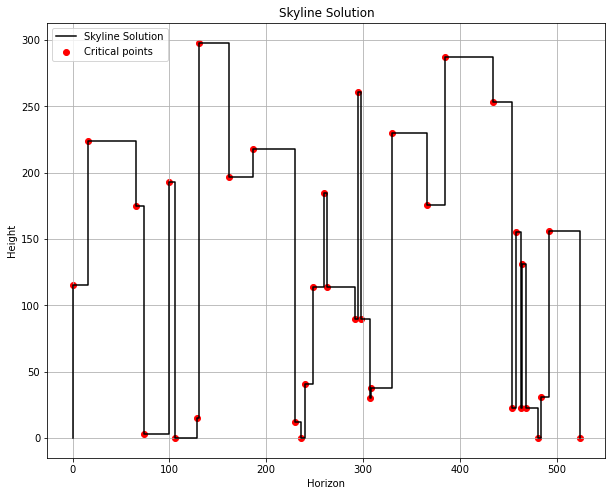

Time used :  0.002991914749145508


In [9]:
points_to_keep, time_used = brute_force_solve(buildings_data)
plot_solution(points_to_keep)
print('Time used : ', time_used)

# Divide to Reign Algorithm

## Definitions

In [10]:
def recombine_solutions(first_group, second_group): 
    index_first_group = 0
    index_second_group = 0
    
    total_index_first_group = len(first_group)
    total_index_second_group = len(second_group)
    
    is_first_group_covered = False
    is_second_group_covered = False
    
    first_element = first_group[index_first_group]
    second_element = second_group[index_second_group]
    
    height_1 = 0
    height_2 = 0
    current_height = 0
    
    current_element = [0, 0]
    new_solution = [[-1, 0]]
    
    while not(is_first_group_covered) or not(is_second_group_covered) :
        if (not(is_first_group_covered) and first_element[0] <= second_element[0]) or is_second_group_covered:
            current_element = first_element
            height_1 = current_element[1]
            
            if current_element[1] < height_2 :
                current_element[1] = height_2
            
            index_first_group += 1
            if index_first_group < total_index_first_group:
                first_element = first_group[index_first_group]
            else:
                is_first_group_covered = True
            
        elif (not(is_second_group_covered) and second_element[0] <= first_element[0]) or is_first_group_covered:
            current_element = second_element
            height_2 = current_element[1]
            
            if current_element[1] < height_1 :
                current_element[1] = height_1
            
            index_second_group += 1
            if index_second_group < total_index_second_group:
                second_element = second_group[index_second_group]
            else:
                is_second_group_covered = True
                
        else :
            print ('ERROR: IMPOSSIBLE STATE')
            break
        
        # Add the points that are not redundant
        previous_point_kept = new_solution[-1]
        if previous_point_kept[1] != current_element[1]:
            if current_element[0] == previous_point_kept[0]:
                if current_element[1] > previous_point_kept[1]:
                    new_solution.pop()
                    new_solution.append(current_element)
                
            else :
                new_solution.append(current_element)
    
    new_solution = np.array(new_solution[1:])
    return new_solution

In [11]:
# Pseudocode :

# Function Divide-to-Reign(x {Sample}) : y {solution}
#     IF is small return brute-force-algorithm(x)
#     Decompose x en 2 sub-samples x_0, x_1
#     FOR i=1 to n do :
#         yi <-- Divide-to-Reign(x_i)
#     Recombine y_n to y
#
#     RETURN y

def divide_to_reign_solve(buildings_data, recursion_threshold=1, must_compute_time=True):
    
    if must_compute_time :
        parent_start_time = time.time()
    
    # IF is small return brute-force-algorithm(x)
    if len(buildings_data) <= max(1, recursion_threshold):
        return brute_force_solve(buildings_data, must_compute_time=must_compute_time)
    
    # Decompose x en 2 sub-samples x_0, x_1
    left_group = None
    right_group = None
    if len(buildings_data) % 2 == 0 :
        splited_buidings_data = np.vsplit(buildings_data[:], 2)
        left_group = splited_buidings_data[0]
        right_group = splited_buidings_data[1]
    else :
        splited_buidings_data = np.vsplit(buildings_data[:-1], 2)
        left_group = splited_buidings_data[0]
        right_group = np.vstack((splited_buidings_data[1], buildings_data[-1]))
        
    # FOR i=1 to n do : yi <-- Divide-to-Reign(x_i)
    left_solution = divide_to_reign_solve(left_group, recursion_threshold=recursion_threshold, must_compute_time=False)
    right_solution = divide_to_reign_solve(right_group, recursion_threshold=recursion_threshold, must_compute_time= False)
    
    # Recombine y_n to y
    solution = recombine_solutions(left_solution, right_solution)
    
    # RETURN y
    if must_compute_time :
        parent_end_time = time.time()
        computation_time = parent_end_time - parent_start_time
        return (solution, computation_time)
    else :
        return solution

## Usage

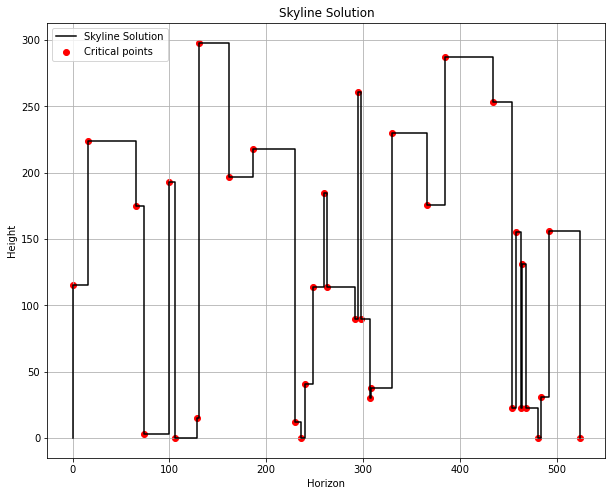

Time used :  0.008974313735961914


In [12]:
solution_reached, time_used = divide_to_reign_solve(buildings_data, recursion_threshold=1)
plot_solution(solution_reached)
print('Time used : ', time_used)

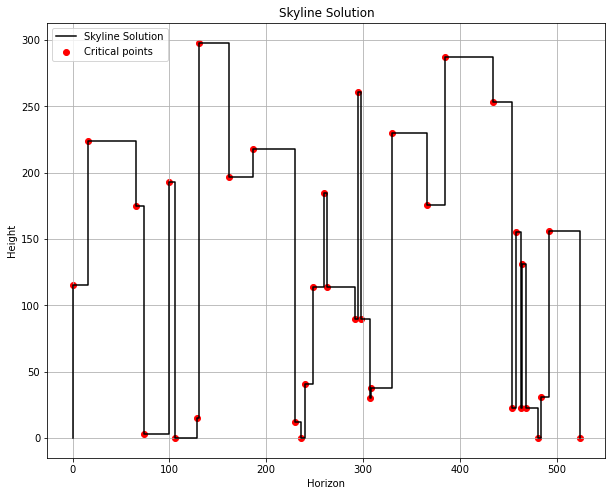

Time used :  0.0019905567169189453


In [13]:
solution_reached, time_used = divide_to_reign_solve(buildings_data, recursion_threshold=25)
plot_solution(solution_reached)
print('Time used : ', time_used)

# Tests

## Data generation

In [14]:
# Data sizes
SIZES = [50, 100, 500, 1000, 5000, 10000]#, 50000, 100000, 500000]
THRESHOLD = 25

In [15]:
# Generate files
buildings_data_list = []
for size in SIZES:
    generated_file_name = generate_data(number_buildings=size)
    buildings_data_list.append(import_data(generated_file_name))

SUCCESS : Data generation with 50 buildings
SUCCESS : Data generation with 100 buildings
SUCCESS : Data generation with 500 buildings
SUCCESS : Data generation with 1000 buildings
SUCCESS : Data generation with 5000 buildings
SUCCESS : Data generation with 10000 buildings


## Performance calculation

In [16]:
list_time_brute_force = []
list_time_divide_to_reign_1 = []
list_time_divide_to_reign_2 = []

print('Brute Force (BF), Divide to Reign Treshold 1 (DR1), Divide to Reign Threshold', THRESHOLD)
for test_data in buildings_data_list:
    points_to_keep, time_brute_force = brute_force_solve(test_data)
    points_to_keep, time_divide_to_reign_1 = divide_to_reign_solve(test_data, recursion_threshold=1)
    points_to_keep, time_divide_to_reign_2 = divide_to_reign_solve(test_data, recursion_threshold=25)
    
    list_time_brute_force.append(time_brute_force)
    list_time_divide_to_reign_1.append(time_divide_to_reign_1)
    list_time_divide_to_reign_2.append(time_divide_to_reign_2)
 
    print('For ', len(test_data), ' Building(s) --> BF:', time_brute_force, '; DR1:', time_divide_to_reign_1, 'DR2: ', time_divide_to_reign_2)

Brute Force (BF), Divide to Reign Treshold 1 (DR1), Divide to Reign Threshold 25
For  50  Building(s) --> BF: 0.004986763000488281 ; DR1: 0.015958070755004883 DR2:  0.006978750228881836
For  100  Building(s) --> BF: 0.036904335021972656 ; DR1: 0.025932788848876953 DR2:  0.013935327529907227
For  500  Building(s) --> BF: 0.42485976219177246 ; DR1: 0.08078265190124512 DR2:  0.03191518783569336
For  1000  Building(s) --> BF: 1.6560795307159424 ; DR1: 0.10870981216430664 DR2:  0.06283044815063477
For  5000  Building(s) --> BF: 41.826160192489624 ; DR1: 0.6333026885986328 DR2:  0.31316494941711426
For  10000  Building(s) --> BF: 133.8677327632904 ; DR1: 1.2137067317962646 DR2:  0.6951394081115723


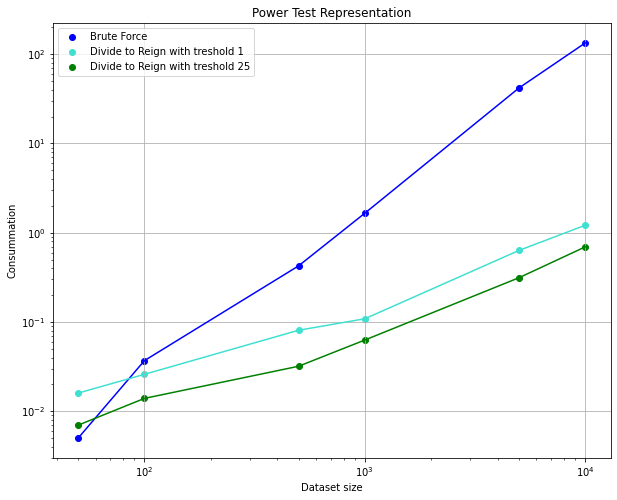

In [17]:
plt.figure(figsize=(10,8))

plt.xscale("log")
plt.yscale("log")

# Brute force Algorithm
plt.plot(SIZES, list_time_brute_force, color='blue')
plt.scatter(SIZES, list_time_brute_force, color='blue', label='Brute Force')

# Divide to reign Algorithm with threshold 1
plt.plot(SIZES, list_time_divide_to_reign_1, color='turquoise')
plt.scatter(SIZES, list_time_divide_to_reign_1, color='turquoise', label='Divide to Reign with treshold 1')

# Divide to reign Algorithm with threshold THRESHOLD
plt.plot(SIZES, list_time_divide_to_reign_2, color='green')
plt.scatter(SIZES, list_time_divide_to_reign_2, color='green', label='Divide to Reign with treshold '+ str(THRESHOLD))

plt.title("Power Test Representation")
plt.xlabel("Dataset size")
plt.ylabel("Consummation")
plt.legend()
plt.grid()
plt.show()

## Power test

In [18]:
def perform_power_test(x_exp, y_exp, label):
    
    # solve linear system
    x = np.log(x_exp)
    y = np.log(y_exp)
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    y_plot = m * x + c
    
    # Plot data
    plt.figure(figsize=(10,8))
    
    # Experimental data
    plt.plot(np.log(x_exp), np.log(y_exp), color='blue')
    plt.scatter(np.log(x_exp), np.log(y_exp), color='blue', label=label)
    
    # Fit linear
    plt.plot(x, y_plot, color='red', label=str(m) + ' x + ' + str(c))
    

    plt.title("Power Test Representation")
    plt.xlabel("Dataset size")
    plt.ylabel("Consummation (power of 10)")
    plt.legend()
    plt.grid()
    plt.show()

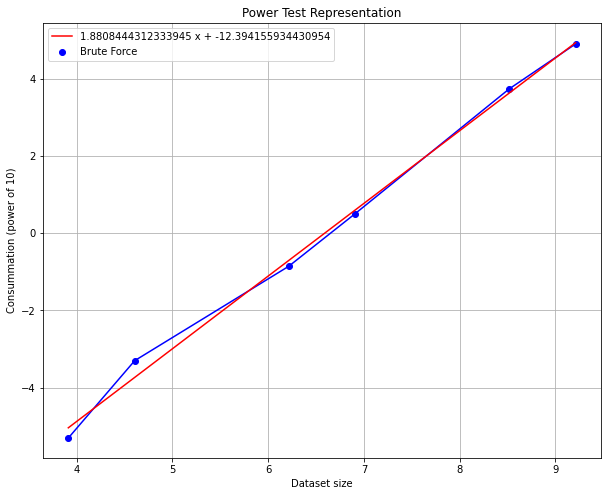

In [19]:
perform_power_test(x_exp=SIZES, y_exp=list_time_brute_force, label='Brute Force')   

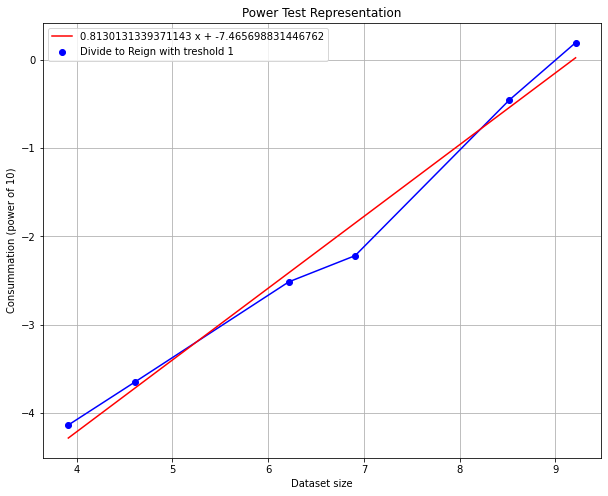

In [20]:
perform_power_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_1, label='Divide to Reign with treshold 1')

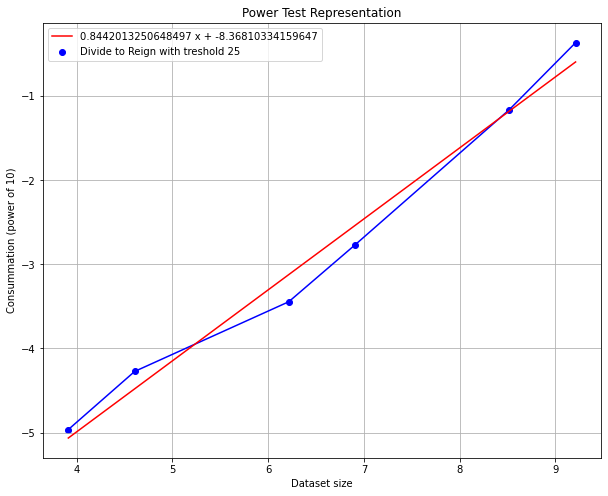

In [21]:
perform_power_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_2, label='Divide to Reign with treshold '+ str(THRESHOLD))

## Ratio Test

In [34]:
def perform_ratio_test(x_exp, y_exp, label):
    
    # Compute ratios
    x = np.array(x_exp)
    y = np.array(y_exp)
    
    y_plot_power_nlog = y/ (x *np.log(x))
    y_plot_power_1 = y/x
    y_plot_power_2 = y/(x**2)
    
    # Plot data
    plt.figure(figsize=(10,8))
    plt.xscale("log")
    plt.yscale("log")
    
    # Plot ratio
    plt.plot(x, y_plot_power_1, color='coral', label='Ratio : y / x')
    plt.plot(x, y_plot_power_nlog, color='orange', label='Ratio : y / xlog(x)')
    plt.plot(x, y_plot_power_2, color='red', label='Ratio : y / (x^2)')

    plt.title("Ratio Test Representation (" + label + ")")
    plt.xlabel("Dataset size")
    plt.ylabel("Consummation Ratio")
    plt.legend()
    plt.grid()
    plt.show()

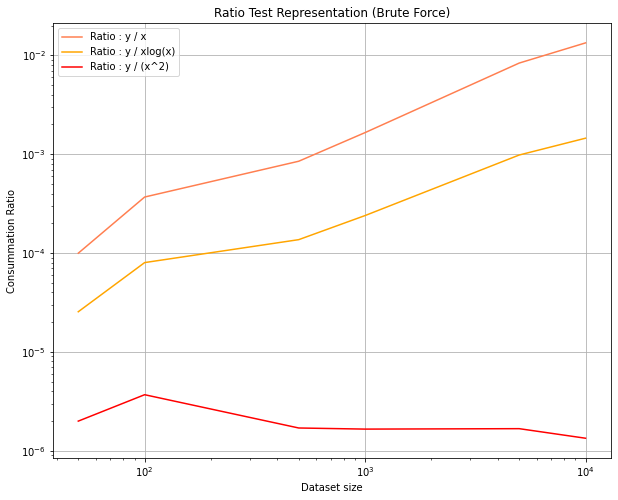

In [35]:
perform_ratio_test(x_exp=SIZES, y_exp=list_time_brute_force, label="Brute Force")   

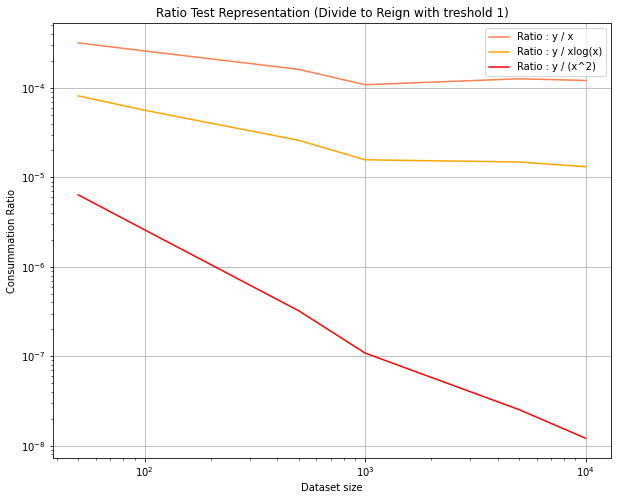

In [36]:
perform_ratio_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_1, label='Divide to Reign with treshold 1')

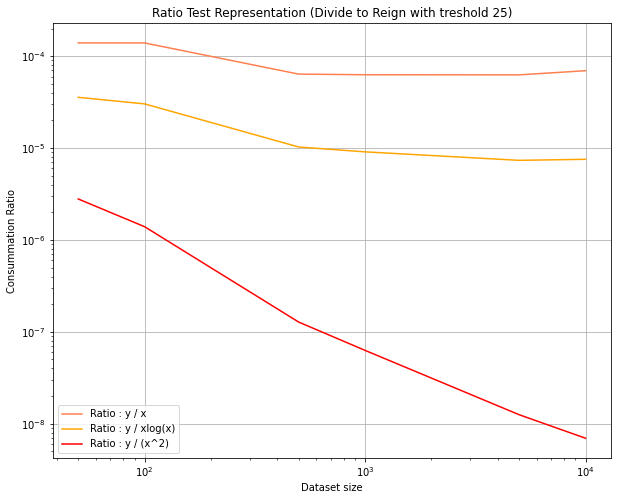

In [37]:
perform_ratio_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_2, label='Divide to Reign with treshold '+ str(THRESHOLD))

## Constant Test

In [26]:
def perform_constant_test(x_exp, y_exp, label, function, function_title='f(x)'):
    
    vectorized_function = np.vectorize(function) 
    
    # solve linear system
    x = np.array(x_exp)
    y = np.array(y_exp)
    
    
    x_base_function = vectorized_function(x)
    A = np.vstack([x_base_function, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    x_plot = np.linspace(min(x_exp), max(x_exp), 100)
    y_plot = m * vectorized_function(x_plot) + c
    
    # Plot data
    plt.figure(figsize=(10,8))
    plt.xscale("log")
    
    # Experimental data
    plt.plot(x_exp, y_exp, color='blue')
    plt.scatter(x_exp, y_exp, color='blue', label=label)
    
    # Fit linear
    plt.plot(x_plot, y_plot, color='red', label=str(m) + ' f(x) + ' + str(c) + ' (' + function_title+ ')')
    

    plt.title("Power Test Representation")
    plt.xlabel("Dataset size")
    plt.ylabel("Consummation (power of 10)")
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
# Funtions
def power_1(x):
    return x

def power_2(x):
    return x**2

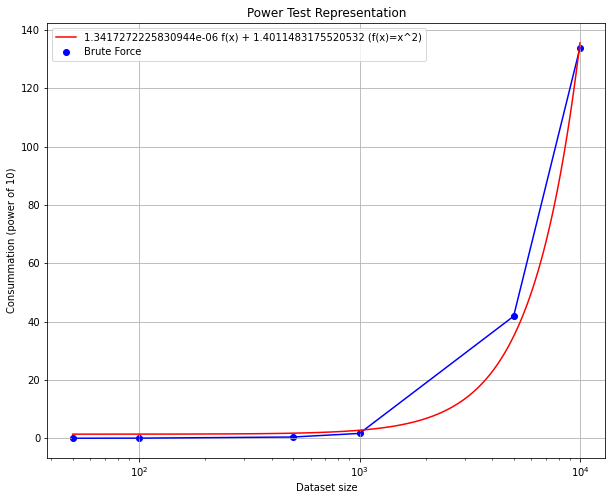

In [28]:
# We have reasons to believe that the function is of the order O(n^2)
perform_constant_test(x_exp=SIZES, y_exp=list_time_brute_force, label="Brute Force", function=power_2, function_title='f(x)=x^2')

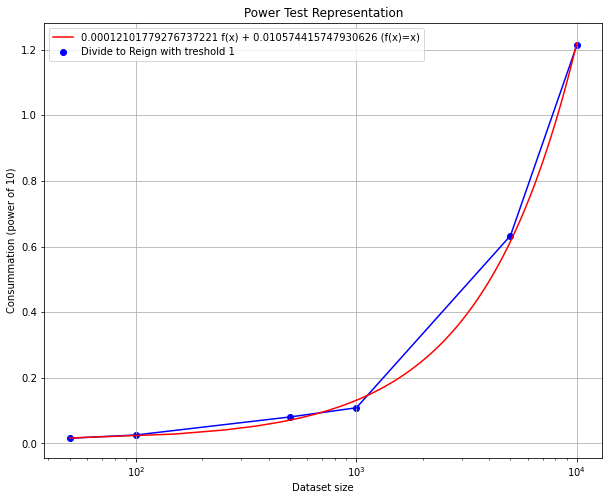

In [29]:
# We have reasons to believe that the function is of the order O(n)
perform_constant_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_1, label='Divide to Reign with treshold 1', function=power_1, function_title='f(x)=x')

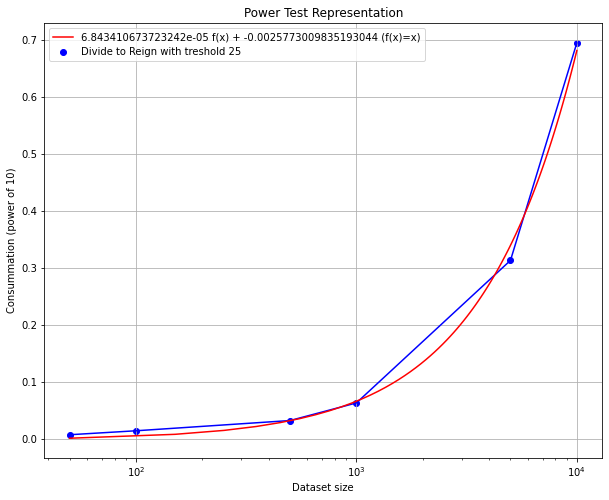

In [30]:
# We have reasons to believe that the function is of the order O(n)
perform_constant_test(x_exp=SIZES, y_exp=list_time_divide_to_reign_2, label='Divide to Reign with treshold '+ str(THRESHOLD), function=power_1, function_title='f(x)=x')

# Script to generate python script

In [31]:
!jupyter nbconvert --to script solution.ipynb

[NbConvertApp] Converting notebook solution.ipynb to script
[NbConvertApp] Writing 15998 bytes to solution.py
